In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from stock import *
from datetime import datetime
import mplfinance as mpf
from torchviz import make_dot

In [2]:
data = load_raw_stock_data("AAPL", interval="1d", period="max")
process_data = clean_data(data)

data = data.to_numpy()
print(data.shape)
print(process_data.shape)

(11079, 5)
(11078, 5)


In [3]:
class StockModel(nn.Module):
    n_features = 5
    n_layers = 1
    
    def __init__(self, n_windows: int = 64, output_size: int = 8):
        super(StockModel, self).__init__()
        self.lstm = nn.LSTM(self.n_features, n_windows, self.n_layers, batch_first=True)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(n_windows, n_windows)
        self.fc2 = nn.Linear(n_windows, n_windows)
        self.fc3 = nn.Linear(n_windows, n_windows)
        self.fc4 = nn.Linear(n_windows, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

model = StockModel(n_windows=64, output_size=8)
print(model)

StockModel(
  (lstm): LSTM(5, 64, batch_first=True)
  (relu): ReLU()
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=8, bias=True)
)


In [4]:
n_windows = 64
n_size = len(process_data)
n_features = len(process_data[0])
n_futures = 8

X = np.zeros((n_size - n_windows - n_futures, n_windows, n_features))

for i in range(n_size - n_windows - n_futures):
    X[i] = process_data[i:i+n_windows]

y = np.zeros((n_size - n_windows - n_futures, n_futures))

for i in range(n_size - n_windows - n_futures):
    for j in range(n_futures):
        y[i][j] = (data[i + n_windows + j + 1][3] / data[i + n_windows + 1][3]) - 1

y = np.array(y)

print(X.shape)
print(y.shape)

(11006, 64, 5)
(11006, 8)


In [5]:
dataset = StockDataset(X, y)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [7]:
model.to("cuda")

for name, param in model.named_parameters():
    print(f"Parameter {name} is on device: {param.device}")

Parameter lstm.weight_ih_l0 is on device: cuda:0
Parameter lstm.weight_hh_l0 is on device: cuda:0
Parameter lstm.bias_ih_l0 is on device: cuda:0
Parameter lstm.bias_hh_l0 is on device: cuda:0
Parameter fc1.weight is on device: cuda:0
Parameter fc1.bias is on device: cuda:0
Parameter fc2.weight is on device: cuda:0
Parameter fc2.bias is on device: cuda:0
Parameter fc3.weight is on device: cuda:0
Parameter fc3.bias is on device: cuda:0
Parameter fc4.weight is on device: cuda:0
Parameter fc4.bias is on device: cuda:0


In [8]:
n_epochs = 50

model.train()
for epoch in range(n_epochs):
    epoch_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"EPOCH {epoch+1}/{n_epochs}: Loss - {epoch_loss/ len(train_loader):.10f}")

EPOCH 1/50: Loss - 0.0045647459
EPOCH 2/50: Loss - 0.0026137492
EPOCH 3/50: Loss - 0.0026142279
EPOCH 4/50: Loss - 0.0026148877
EPOCH 5/50: Loss - 0.0026109222
EPOCH 6/50: Loss - 0.0026103657
EPOCH 7/50: Loss - 0.0026117423
EPOCH 8/50: Loss - 0.0026112402
EPOCH 9/50: Loss - 0.0026180970
EPOCH 10/50: Loss - 0.0026116778
EPOCH 11/50: Loss - 0.0026122829
EPOCH 12/50: Loss - 0.0026138022
EPOCH 13/50: Loss - 0.0026158946
EPOCH 14/50: Loss - 0.0026109152
EPOCH 15/50: Loss - 0.0026084682
EPOCH 16/50: Loss - 0.0026077777
EPOCH 17/50: Loss - 0.0026166953
EPOCH 18/50: Loss - 0.0026129114
EPOCH 19/50: Loss - 0.0026076363
EPOCH 20/50: Loss - 0.0026148480
EPOCH 21/50: Loss - 0.0026108499
EPOCH 22/50: Loss - 0.0026087355
EPOCH 23/50: Loss - 0.0026079541
EPOCH 24/50: Loss - 0.0026047966
EPOCH 25/50: Loss - 0.0026113691
EPOCH 26/50: Loss - 0.0026084893
EPOCH 27/50: Loss - 0.0026070399
EPOCH 28/50: Loss - 0.0026081243
EPOCH 29/50: Loss - 0.0026082044
EPOCH 30/50: Loss - 0.0026076328
EPOCH 31/50: Loss -

In [10]:
test_x = torch.tensor(X[-1].reshape(1, 64, 5), dtype=torch.float32).to("cuda")

y_pred = model(test_x)
y_pred = y_pred.cpu().detach().numpy()
y_pred = y_pred.reshape(8,)

close = data[-9][3]

for i in range(8):
    y_pred[i] = close * (1 + y_pred[i])

y_pred

array([224.29637, 224.13017, 224.22163, 224.77641, 224.56898, 225.05313,
       225.4751 , 225.94707], dtype=float32)

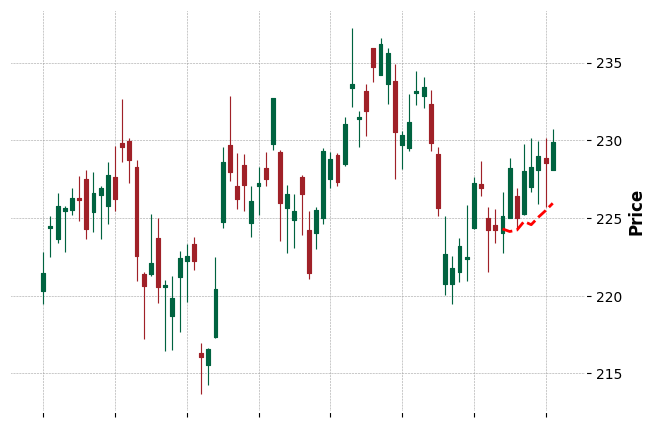

In [11]:
plot_data = data[-64-8:]
df = pd.DataFrame(plot_data, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
df.index = pd.date_range("2023-01-01", periods=len(df), freq="D")

fig, ax = mpf.plot(
    df,
    type='candle',
    style='charles',
    datetime_format='',
    volume=False,
    returnfig=True,
)

x_pred = np.arange(len(df.index) - 8, len(df.index)) 

ax[0].plot(x_pred, y_pred, label='Predictive Trend', linestyle='--', color='red')

plt.show()